## Install Python dependencies

In [1]:
!pip install boto3 pandas numpy sagemaker

## Import Libraries

In [2]:
!pip uninstall kfp -y
!pip install kfp

Found existing installation: kfp 1.8.10
Uninstalling kfp-1.8.10:
  Successfully uninstalled kfp-1.8.10
  Using cached kfp-1.8.10-py3-none-any.whl


In [21]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [32]:
import kfp
import kfp.dsl as dsl
from kfp import components
from kubernetes import client as k8s_client
from kfp.aws import use_aws_secret
import logging
import os
import boto3
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sagemaker
from datetime import datetime
from sagemaker.predictor import Predictor
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import NumpyDeserializer

## Quick look at training data

In [33]:
train_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv"
df_train = pd.read_csv(
    train_url, parse_dates=True, index_col="timestamp")
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
df_train.head()

Number of training samples: 4032


,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


## Visualize training data

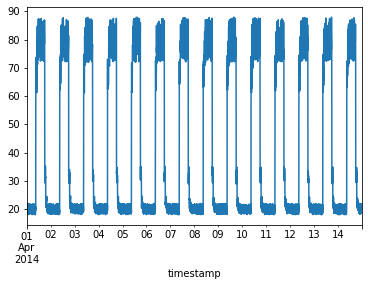

In [34]:
fig, ax = plt.subplots()
df_train.plot(legend=False, ax=ax)
plt.show()

## Set Pipeline parameters

In [35]:
# execution_mode (string): where the notebook is being run
# Sample: 'local', 'in-cluster'
execution_mode = 'in-cluster'

# host (string): KF Pipelines service endpoint
host = ''

# bucket_name (string): S3 bucket to be used by the pipeline
bucket_name = 'model-store-aws'

# aws_secret_name (string): AWS secret where IAM creds are stored
# Sample: 'aws-secret'
aws_secret_name = 'aws-secret'

# role_arn (string): SageMaker Role ARN for execution of pipeline components
# Sample: 'arn:aws:iam::${account_id}:role/service-role/AmazonSageMaker-ExecutionRole-${timestemp}'
role_arn = 'arn:aws:iam::315482734496:role/SageMakerServingRole'

# Region where the pipeline is supposed to push/pull artifacts
aws_region = 'ap-south-1'
%env AWS_DEFAULT_REGION={aws_region}

timestamp = datetime.now().strftime("%d-%m-%y-%H-%M-%S")
logging.info("timestamp for pipeline artifacts: %s", timestamp)

# pre-built inference image for serving the anomaly prediction model
inference_image = '315482734496.dkr.ecr.ap-south-1.amazonaws.com/anomalypredict:0.5'

# model name to create a re-usable SageMaker Model resource
model_name = 'anomalyprediction-model-'+timestamp

# endpoint config name for the SageMaker Model Serving Endpoint Config
endpoint_config_name = 'anomalyprediction-endpoint-config-'+timestamp

# endpoint name for SageMaker Serving Endpoint
endpoint_name = 'anomalyprediction-endpoint-'+timestamp

# model artifact URL
# Path to the model tarball 
model_path= 's3://'+bucket_name+'/model/anomalydetection_model.tar.gz'

# AWS instance type
instance_type = 'ml.m4.xlarge'

INFO:root:timestamp for pipeline artifacts: 06-01-22-06-27-46


env: AWS_DEFAULT_REGION=ap-south-1


In [36]:
model = 'https://raw.githubusercontent.com/kubeflow/pipelines/master/components/aws/sagemaker/model/component.yaml'
deploy = 'https://raw.githubusercontent.com/kubeflow/pipelines/master/components/aws/sagemaker/deploy/component.yaml'

if execution_mode == "local" and host == None:
    raise ValueError("Please set host to the appropriate URL")
elif execution_mode != "local":
    execution_mode = "in-cluster"

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

## Define Pipeline Steps

In [37]:
sagemaker_model_op = components.load_component_from_url(model)
sagemaker_deploy_op = components.load_component_from_url(deploy)

def anomalyprediction_train_upload_op(step_name='anomalyprediction-train'):
    vop = dsl.VolumeOp(
      name='Mount-Log-Volume',
      resource_name="tensorboard-pvc",
      modes=["ReadWriteOnce"],
      size="1Gi"
    )
        
    return dsl.ContainerOp(
        name='Train-Keras-Model',
        image='johnugeorge/anomalytrain:0.6',
        command=['python', '/opt/anomalytrain.py'],
        arguments=['--s3bucket', bucket_name, '--logsdir', '/mnt/vol'],
        pvolumes={"/mnt/vol": vop.volume}
    ).apply(use_aws_secret(secret_name=aws_secret_name, aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))

In [38]:
@dsl.pipeline(
    name='Sagemaker Hybrid Pipeline',
    description='Pipeline to train Anomaly Prediction model using keras and save in aws s3 bucket'
)
def tf_pipeline(
    region="",
    image="",
    model_name="",
    endpoint_config_name="",
    endpoint_name="",
    model_artifact_url="",
    instance_type_1="",
    role=""
):
    train_upload_model = anomalyprediction_train_upload_op()

    create_model = sagemaker_model_op(
        region=region,
        model_name=model_name,
        image=image,
        model_artifact_url=model_artifact_url,
        role=role
    ).apply(use_aws_secret(secret_name=aws_secret_name, aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    create_model.after(train_upload_model)

    sagemaker_deploy=sagemaker_deploy_op(
        region=region,
        endpoint_config_name=endpoint_config_name,
        endpoint_name=endpoint_name,
        model_name_1=create_model.output,
        instance_type_1=instance_type_1
    ).apply(use_aws_secret(secret_name=aws_secret_name, aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    sagemaker_deploy.after(create_model)

## Compile Pipeline Workflow

In [39]:
try:
    import kfp.compiler as compiler
    compiler.Compiler().compile(tf_pipeline, 'e2e_pipeline.tar.gz')
except RuntimeError as err:
    logging.debug(err)
    logging.info("Argo workflow failed validation check but it can still be used to run experiments.")


/opt/conda/lib/python3.8/site-packages/kfp/dsl/_container_op.py:1258: FutureWarning: Please create reusable components instead of constructing ContainerOp instances directly. Reusable components are shareable, portable and have compatibility and support guarantees. Please see the documentation: https://www.kubeflow.org/docs/pipelines/sdk/component-development/#writing-your-component-definition-file The components can be created manually (or, in case of python, using kfp.components.create_component_from_func or func_to_container_op) and then loaded using kfp.components.load_component_from_file, load_component_from_uri or load_component_from_text: https://kubeflow-pipelines.readthedocs.io/en/stable/source/kfp.components.html#kfp.components.load_component_from_file
  warnings.warn(


## Create Pipeline experiment

In [40]:
client = None
if execution_mode == "local":
    client = kfp.Client(host=host)
else:
    client = kfp.Client()
print(execution_mode)
e2e_hybrid_experiment = client.create_experiment(name='AnomalyPrediction',namespace='kubeflow-user-example-com')


in-cluster


## Create Pipeline Run

In [41]:
run = client.run_pipeline(e2e_hybrid_experiment.id, 'anomalyprediction-sagemaker-pipeline-'+timestamp, pipeline_package_path='e2e_pipeline.tar.gz', params={
    'region': aws_region,
    'image': inference_image,
    'model_name': model_name,
    'endpoint_config_name': endpoint_config_name,
    'endpoint_name': endpoint_name,
    'model_artifact_url': model_path,
    'instance_type_1': instance_type,
    'role': role_arn
})

## Check deployed Sagemaker Endpoint status

In [16]:
sagemaker_session = sagemaker.Session()
sg_client = boto3.client('sagemaker', region_name='ap-south-1')
resp = sg_client.describe_endpoint(EndpointName=endpoint_name)
resp['EndpointStatus']

'InService'

In [17]:
predictor = Predictor(endpoint_name=endpoint_name,sagemaker_session=sagemaker_session,serializer=NumpySerializer(),deserializer=NumpyDeserializer())

## Visualize test data

Number of test samples: 4032


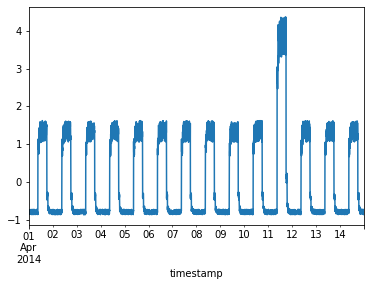

In [18]:
test_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv"
df_test = pd.read_csv(
    test_url, parse_dates=True, index_col="timestamp")
df_test_value = (df_test - training_mean) / training_std
print("Number of test samples:", len(df_test_value))
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

## Send Prediction Requests to Sagemaker

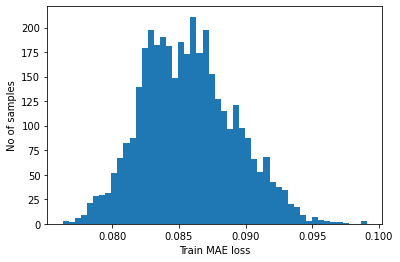

Reconstruction error threshold:  0.09909492287211184


In [19]:
TIME_STEPS = 288
def create_sequences(values, time_steps=288):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

def predict(test_values, split =1500):
    res = None
    for i in range(0, len(test_values), split):
        test_split = test_values[i: i +split]
        test_pred = predictor.predict(data=test_split, initial_args={'ContentType': 'application/x-npy'})
        res = test_pred if res is None else np.vstack([res,test_pred])
    return res

# Create sequences from test values.
x_train = create_sequences(df_training_value.values)
x_train_pred = predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test_pred = predict(x_test)
# Get test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Plot Anomalies

Number of anomaly samples:  413


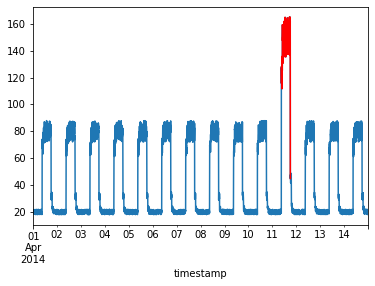

In [20]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss >threshold
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()